# Import packages

In [336]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

## Price Simulation with a Random Walk

We model the dynamics of stock prices using a random walk. This model is mathematically expressed as:

$ P_{t+1} = P_t +\epsilon_t $

Here, $P_0$  represents the initial stock price, and each $\epsilon_t$ denotes the daily price change. The changes $\epsilon_t$ are assumed to be independent and identically distributed (i.i.d.) random variables following a normal distribution $\mathcal{N}(0,1) $.


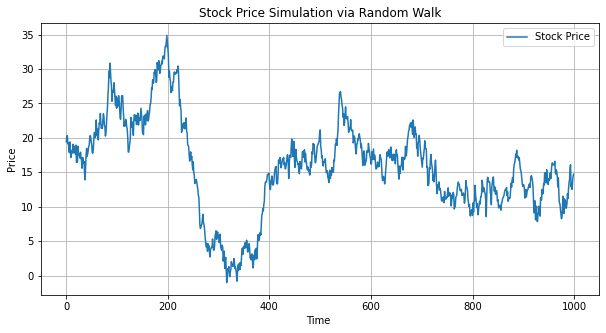

In [337]:
# Initialization of parameters
NIT = 1000
initial_price = 20

# Generate random price changes
price_changes = np.random.normal(0, 1, size=NIT)

# Calculate stock prices
stock_prices = initial_price + np.cumsum(price_changes)

# Time steps for plotting
time_steps = np.arange(NIT)

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(time_steps, stock_prices, label="Stock Price")
plt.title("Stock Price Simulation via Random Walk")
plt.xlabel("Time ")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


## Define Strategies

Each trading strategy defined below uses historical price data (`p`) and returns (`r`) to determine trading signals. Here is a brief explanation and the mathematical definition of each strategy:

### Strategy 1: Negative Feedback
This strategy simply takes the negative sign of the last return.
$$ a_{1,t} = -\text{sign}(r_{t-1}) $$

### Strategy 2: Positive Feedback
This strategy follows the sign of the last return.
$$ a_{2,t} = \text{sign}(r_{t-1}) $$

### Strategy 3: Product Sign
Determines the action based on the product of the last two returns.
$$ a_{3,t} = \text{sign}(r_{t-1} \cdot r_{t-2}) $$

### Strategy 4: Trend Following (Moving Average)
Calculates a moving average and buys if the current price is higher.
$$ a_{4,t} = \text{sign}(p_{t-1} - MA_k) $$
where $$ MA_k = \frac{1}{k} \sum_{i=0}^{k-1} p_{t-i-1} $$.

### Strategy 5: Mean Reverting (Moving Average)
Calculates a moving average and buys if the current price is lower.
$$ a_{5,t} = \text{sign}(MA_k - p_{t-1}) $$

### Strategy 6: Smooth Sign with Hyperbolic Tangent
Uses a smooth approximation to the sign function.
$$ a_{6,t} = \tanh(r_{t-1}) $$

Each strategy utilizes past data differently, providing a variety of responses based on market conditions.


In [338]:
def strat1(t, p, r, k):
    if len(r)< 1 :
        return 0
    rt = r[:,t-1]
    return -np.sign(rt)

def strat2(t, p, r, k):
    if len(r)< 1 :
        return 0
    rt = r[:,t-1]
    return np.sign(rt)

def strat3(t, p, r, k):
    if len(r)< 2 :
        return 0
    return np.sign(r[:,t-1] * r[:,t-2])


def strat4(t, p, r, k):
    if len(p)< k :
        return 0
    p_pred = p[:,t-k:t]
    MA = np.mean(p_pred, axis= 1)
    return np.sign(p[:,t-1] - MA)

def strat5(t, p, r, k):
    if len(p)< k :
        return 0
    p_pred = p[:,t-k:t]
    MA = np.mean(p_pred, axis= 1)
    return np.sign(MA - p[:,t-1])

def strat6(t, p, r, k):
    if len(r)< 1 :
        return 0
    rt = r[t-1]
    return np.tanh(rt)  # Using hyperbolic tangent as a smooth approximation of sign


### Exemple of influence of strategie 2 

#### comparaison with agent influence and without influence

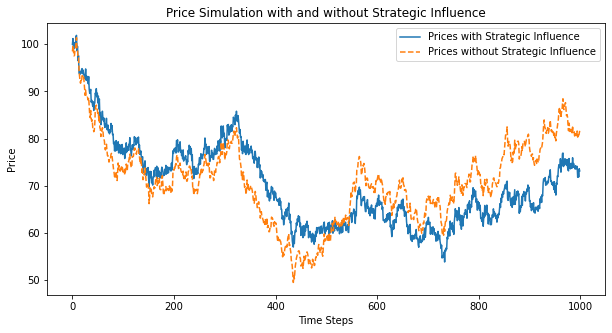

In [339]:
# Simulation parameters
NIT = 1000
phi1 = 1.0
initial_price=100


epsilon = np.random.normal(0, 1, NIT)
p = np.zeros(NIT).reshape(1,NIT)
p[0] = initial_price
r = np.zeros(NIT).reshape(1,NIT)


# Apply the strategy
for t in range(1, NIT):
    action = strat1(t, p[:, :t], r[:, :t], 0)
    r[:,t] = epsilon[t] + phi1 * action
    p[:,t] = p[:, t-1] + r[:, t]

p = p.reshape(NIT)
r = r.reshape(NIT)
# Plot prices
plt.figure(figsize=(10, 5))
plt.plot(p, label='Prices with Strategic Influence')
plt.plot(np.cumsum(epsilon) + initial_price, label='Prices without Strategic Influence', linestyle='--')
plt.title('Price Simulation with and without Strategic Influence')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

Variance of returns: 1.9391545773249843, Variance of epsilon: 0.9394567510793301


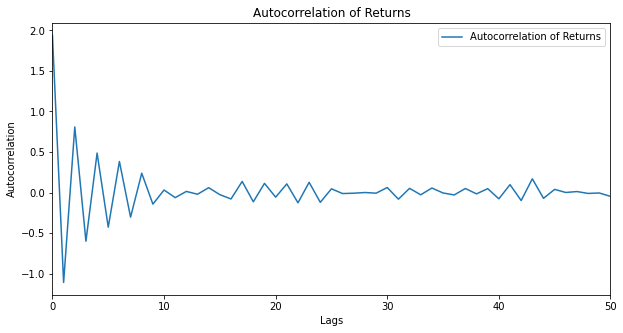

In [340]:

# Compute variance of returns and compare with shocks
var_returns = np.var(r)
var_shocks = np.var(epsilon)
print(f"Variance of returns: {var_returns}, Variance of epsilon: {var_shocks}")

# Plot autocorrelation of returns
autocorr_returns = np.correlate(r, r, mode='full')
autocorr_returns = autocorr_returns[len(autocorr_returns)//2:] / NIT  # Normalize

plt.figure(figsize=(10, 5))
plt.plot(autocorr_returns, label='Autocorrelation of Returns')
plt.title('Autocorrelation of Returns')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.xlim(0, 50)  
plt.legend()
plt.show()




In [344]:
# Lag-1 autocorrelation
lag1_autocorr = np.correlate(r[1:], r[:-1], mode='valid') / np.var(r)
print(f"Lag-1 Autocorrelation of Returns: {lag1_autocorr[0]}")

Lag-1 Autocorrelation of Returns: -572.4518003732329


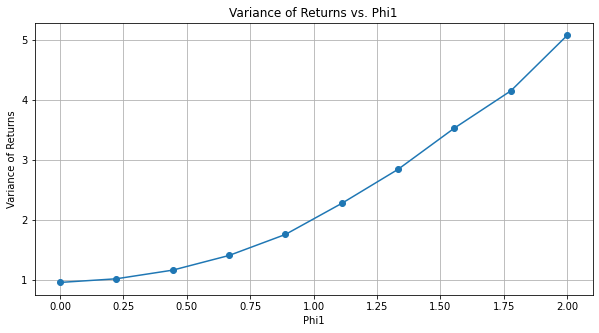

In [327]:
# Explore the influence of varying phi1
phis = np.linspace(0, 2, 10)
r = np.zeros((10,NIT))
p = np.zeros((10,NIT))

for t in range(1, NIT):
    action = strat1(t, p[:, :t], r[:, :t], 0)
    r[:,t] = epsilon[t] + phis* action
    p[:, t] = p[:, t-1] + r[:, t]

variances = np.var(r, axis = 1)
plt.figure(figsize=(10, 5))
plt.plot(phis, variances, marker='o')
plt.title('Variance of Returns vs. Phi1')
plt.xlabel('Phi1')
plt.ylabel('Variance of Returns')
plt.grid(True)
plt.show()



## Market Simulation with Multiple Trading Strategies

This Python function `simulate_market` simulates stock market prices using multiple trading strategies. The effects of these strategies are combined linearly with weights $\phi_i$, which are dynamically assigned while ensuring their sum does not exceed 2.

### Mathematical Description

- **Epsilon ($\epsilon$)**: Represents random daily price shocks, modeled as $\epsilon_t \sim N(0,1)$.

- **Price and Returns Calculation**:
  The returns $r_t$ and prices $p_t$ are updated iteratively as follows:
  $$
  r_t = \epsilon_t + \sum_{i} \phi_i \cdot a_{i,t}
  $$
  $$
  p_t = p_{t-1} + r_t
  $$
  where $a_{i,t}$ denotes the action taken by strategy $i$ at time $t$.


### Outputs

The function returns arrays of returns ($r$), prices ($p$), the variance of returns, and their autocorrelation, providing metrics to evaluate the market dynamics under the influence of the combined strategies.


In [260]:
strats = {1: strat1, 2: strat2, 3: strat3, 4: strat4, 5: strat5, 6: strat6}
def simulate_market(NIT, k=3, strategies=[1, 2]):
    # Generating random weights phi such that sum(phi) <= 2
    phi = np.random.rand(len(strategies))
    phi /= phi.sum() / 2  # Scaling to make sure sum(phi) <= 2

    # Initializations
    epsilon = np.random.normal(0, 1, NIT)
    p = np.zeros(NIT)
    r = np.zeros(NIT)

    # Market simulation loop
    for t in range(1, NIT):
        a_t = sum(phi[i] * strats[strategies[i]](r p, t, k)
                   for i in range(len(strategies)))
        r[t] = epsilon[t] + a_t
        p[t] = p[t-1] + r[t]

    # Output results and statistics
    return r, p, np.var(r), np.correlate(r, r, mode='full')[NIT-1] / NIT

# Example usage
r, p, variance, autocorrelation = simulate_market(1000, strategies=[1, 2, 4])
print("Variance of returns:", variance)
print("Autocorrelation of returns:", autocorrelation)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (3932436753.py, line 14)

In [345]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_market(NIT, phi1, phi2=0, k=3, strat='strat1'):
    epsilon = np.random.normal(0, 1, NIT)
    p = np.zeros(NIT)
    r = np.zeros(NIT)

    # Strategy function definitions
    def strat1(rt):
        return -np.sign(rt)
    
    def strat2(rt):
        return np.sign(rt)
    
    def strat3(r, t):
        if t > 0:
            return np.sign(r[t-1] * r[t-2])
        return 1
    
    def strat4(p, r, t, k):
        if t >= k:
            p_pred = p[t-k:t]
            MA = np.mean(p_pred)
            return np.sign(p[t-1] - MA)
        return 0

    # Simulation loop
    for t in range(1, NIT):
        if strat == 'strat1':
            a_t = strat1(r[t-1])
        elif strat == 'strat2':
            a_t = strat2(r[t-1])
        elif strat == 'strat3':
            a_t = strat3(r, t)
        elif strat == 'strat4':
            a_t = strat4(p, r, t, k)
        
        r[t] = epsilon[t] + phi1 * a_t
        if t >= 1:  # Ensure we don't use uninitialized returns
            p[t] = p[t-1] + r[t]

    # Plotting
    plt.figure(figsize=(14, 7))
    plt.plot(p+20, label='Price p_t')
    plt.title(f"Price Simulation using {strat}")
    plt.xlabel('Time t')
    plt.ylabel('Price p_t')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Variance and autocorrelation calculations
    print("Variance of returns:", np.var(r))
    print("Autocorrelation of returns:", np.correlate(r, r, mode='full')[NIT-1] / NIT)

simulate_market(NIT=1000, phi1=[1.0,2.0], strat='strat2')


TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [348]:
import numpy as np

def generate_array_random_sum(max_sum=2, size=10):
    # Générer des nombres aléatoires
    random_numbers = np.random.rand(size)
    # Générer une somme aléatoire entre 0 et max_sum (non-inclus)
    target_sum = np.random.uniform(0, max_sum)
    # Normaliser les nombres pour atteindre la somme cible
    sum_random_numbers = np.sum(random_numbers)
    normalized_numbers = (random_numbers / sum_random_numbers) * target_sum
    return normalized_numbers

# Exemple d'utilisation
array = generate_array_random_sum()
print(array)
print("Sum of elements:", np.sum(array))


[0.10207524 0.09667334 0.09839981 0.05065622 0.00420542 0.00129105
 0.01382145 0.01925537 0.0561321  0.1140052 ]
Sum of elements: 0.5565152099531032


(array([ 99.,  99., 103., 101., 101.,  95., 104.,  92., 109.,  97.]),
 array([1.73121093e-03, 2.01537005e-01, 4.01342798e-01, 6.01148592e-01,
        8.00954386e-01, 1.00076018e+00, 1.20056597e+00, 1.40037177e+00,
        1.60017756e+00, 1.79998335e+00, 1.99978915e+00]),
 <BarContainer object of 10 artists>)

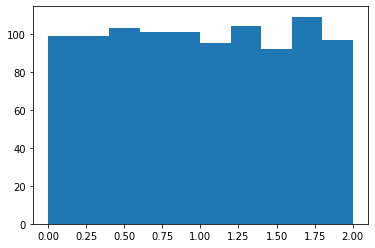

In [246]:
m = np.array([generate_array_random_sum().sum() for k in range(1000)])
plt.hist(m)

In [355]:
import numpy as np

def generate_matrix_vectorized(n, m, max_sum=2):
    # Générer une matrice de nombres aléatoires dans l'intervalle [0, 2]
    random_matrix = np.random.rand(n, m) * 2
    # Calculer la somme de chaque ligne
    row_sums = np.sum(random_matrix, axis=1)
    # Trouver les lignes où la somme dépasse max_sum
    scale_factors = np.minimum(max_sum / row_sums, 1)
    # Normaliser les lignes en utilisant les facteurs d'échelle calculés
    normalized_matrix = random_matrix * scale_factors[:, np.newaxis] * np.random(size = m)
    return normalized_matrix

# Exemple d'utilisation
n = 5  # Nombre de lignes
m = 4  # Nombre de colonnes
matrix = generate_matrix_vectorized(n, m)
print(matrix)
print("Sum of each row:", np.sum(matrix, axis=1))


TypeError: 'module' object is not callable